In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from nicks_plot_utils import *
from lmfit import Model
from lmfit.models import *

import logging
logging.getLogger().setLevel(logging.CRITICAL)

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_PURPLE=plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COLOR_ORANGE=plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
COLOR_PINK=plt.rcParams['axes.prop_cycle'].by_key()['color'][5]
COLOR_LIGHTBLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][6]
plt.rcParams['legend.title_fontsize'] = 'xx-small'


overlapSettings = {"E99-107": {"name": "E99-107",
                               "color": COLOR_RED,
                               "symbol": '*',},
                   "kijun": {"name": "K. Park 2014",
                                    "color": COLOR_DGREEN,
                                    "symbol": 'd',},
                   }

which_plot = {
    -1.0: [0, 0],
    -0.8: [0, 1],
    -0.6: [1, 0],
    -0.4: [1, 1],
    -0.2: [2, 0],
    0.0: [2, 1],
    0.2: [3, 0],
    0.4: [3, 1],
    0.6: [4, 0],
    0.8: [4, 1]
}
plot_label = {
    -1.0: "$\cos(\\theta)=[-1.0,-0.8)$",
    -0.8: "$\cos(\\theta)=[-0.8,-0.6)$",
    -0.6: "$\cos(\\theta)=[-0.6,-0.4)$",
    -0.4: "$\cos(\\theta)=[-0.4,-0.2)$",
    -0.2: "$\cos(\\theta)=[-0.2,0.0)$",
    0.0: "$\cos(\\theta)=[0.0,0.2)$",
    0.2: "$\cos(\\theta)=[0.2,0.4)$",
    0.4: "$\cos(\\theta)=[0.4,0.6)$",
    0.6: "$\cos(\\theta)=[0.6,0.8)$",
    0.8: "$\cos(\\theta)=[0.8,1.0)$"
}

from maid_interface import maid_2007_Npi as maid

xs = np.linspace(0,2*np.pi,200)

TOPFAC = 1.5

def get_maid_values(w, q2, theta):
    ENERGY = 4.81726
    crossSections = []
    for phi in xs:
        crossSections.append(maid(ENERGY, w, q2, theta, np.degrees(phi)))

    return np.array(crossSections)


def plot_maid_model(ax, w, q2, theta, name=""):
    # Get the cross section values from maid
    crossSections = get_maid_values(w, q2, theta+0.1)
    # _ax = ax.twinx()
    ax.plot(xs, crossSections, c='r', linestyle='dotted', label=f"{name}")
    # ax.set_ylim(bottom=0, top=np.max(crossSections)*1.5)

    return np.max(crossSections)*TOPFAC


def A(M, B, C):
    if (C > 0 and np.abs(B) <= 4*C):
        return M**2 + B**2/(8*C) + C
    else:
        return M**2 + np.abs(B) - C

def model(x, M, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = A(M, b, c) + b * np.cos(2*x) + c * np.cos(x)
    return f

def fit_model(ax, x, y, color, func=model, error=None):
    # Make model from function
    model = Model(func)
    # Make fit parameters
    params = model.make_params()
    # Make sure to set inital values to 1
    # so fit doesn't fail
    for p in params:
        params[p].set(value=1)

    # Fit the model
    try:
        out = model.fit(y, params, x=x, weights=(1.0/error) if error is not None else 1.0)
    except ValueError as e:
        print(e)
        return None
    except TypeError as e:
        print(e)
        return None

    # Plot the fitted model with output parameters and same x's as model
    ax.plot(xs, out.eval(params=out.params, x=xs),
            linewidth=2.0, c=color, alpha=0.2)

    return out


In [11]:
# df5 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results_5.csv", index_col=0)
# df5.head()


df5 = pd.read_csv("/Users/tylern/Desktop/show/plots/e1d/test/crossSections/full_results_10.csv", index_col=0)
df5.head()


# df6 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results_6.csv", index_col=0)
# df6.head()

# df7 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results_7.csv", index_col=0)
# df7.head()

# df8 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results_8.csv", index_col=0)
# df8.head()

# df9 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results_9.csv", index_col=0)
# df9.head()

df10 = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results.csv", index_col=0)
df10.head()

overlap = pd.read_csv("/Users/tylern/github/crossSectionPlotter/overlap_data_test.csv")
overlap.head()

alldata = {
       5: {'df': df5},
#        6: {'df': df6},
#        7: {'df': df7},
#        8: {'df': df8},
#        9: {'df': df9},
       10: {'df': df10}
       }


In [12]:
ws = df10.w_left.unique()
q2s = df10.q2_left.unique()
cts = df10.cos_theta.unique()

In [13]:
def plotOne(w, q2, ct):
    w_left = 0
    w_right = 0
    q2_left = 0
    q2_right = 0
    ct_left = 0
    ct_right = 0

    fig, ax = plt.subplots(figsize=[12,6])
    maxs = 0.0
    for k, v in overlapSettings.items():
        odata = overlap[(overlap.W_min == w) & (overlap.Q2_min == q2) & (overlap.cos_t == ct) & (overlap.experiment == k)]
        if len(odata) == 0:
            continue
        plt.errorbar(odata.phi, odata.y, yerr=odata.yerr, marker=v['symbol'], label=f"{v['name']}", linestyle="", c=v['color'], markersize=10)
        maxs = np.max(odata.y)
    
    for bins, dat in alldata.items():
        df = dat['df']
        data = df[(df.w_left == w) & (df.q2_left == q2) & (df.cos_theta == ct)]
        if len(data) == 0:
            continue
    
        w_left = data.w_left.iloc[0]
        w_right = data.w_right.iloc[0]
        q2_left = data.q2_left.iloc[0]
        q2_right = data.q2_right.iloc[0]
        ct_left = data.cos_theta.iloc[0]
        ct_right = np.round(data.cos_theta.iloc[0] + 0.2, 1)

        errorCut = (data.err < 1.0)
        ebar = plt.errorbar(data[errorCut].x, data[errorCut].y, yerr=data[errorCut].err, fmt='.', markersize=10, label=f"$E1D$")
        # plt.errorbar(data[~errorCut].x, data[~errorCut].y, yerr=data[~errorCut].err, fmt='.', markersize=10, label=f"$\cos(\\theta)$ [{ct},{ct+0.2:0.1f})")
    
        out = fit_model(ax, data[errorCut].x, data[errorCut].y, ebar[0].get_color(), error=data[errorCut].err)

        maid_top = plot_maid_model(ax, w, q2, ct, name="MAID2007")


    ax.legend(loc='upper right')
    ax.set_ylabel(r'$\frac{\mathbf{d}\sigma}{\mathbf{d} \Omega} \left[\frac{\mu b}{sr}\right]$')
    ax.set_xlabel(r'$\phi_{\pi}^{*}$')
    ax.set_title(f"$W~:~[{w_left},{w_right})~GeV~~~Q^2~:~[{q2_left},{q2_right})~GeV^2~~~\cos(\\theta)~:~[{ct_left},{ct_right})$")

    try:
        top = np.max(data.y)*TOPFAC
    except ValueError:
        top = np.nan
    

    if np.isnan(top) or np.isinf(top):
        ax.set_ylim(bottom=0, top=1.0)
    else:
        ax.set_ylim(bottom=0, top=max(max(top, maid_top), maxs))


    plt.xlim(0, 2*np.pi)
    plt.tight_layout()

Improper input: N=3 must not exceed M=0
Improper input: N=3 must not exceed M=0
Improper input: N=3 must not exceed M=0


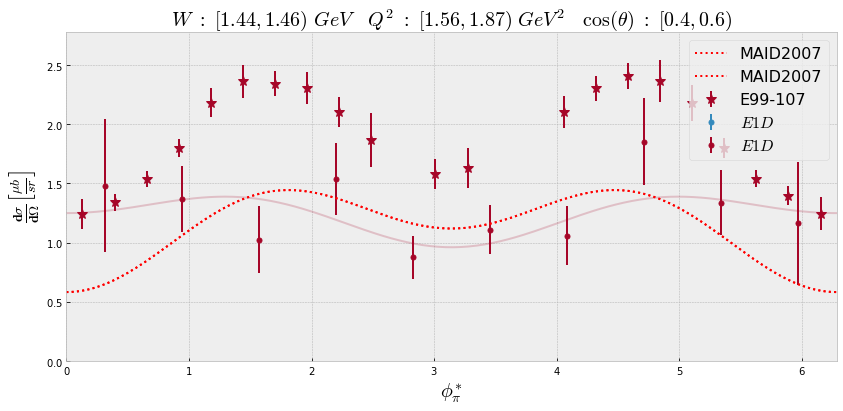

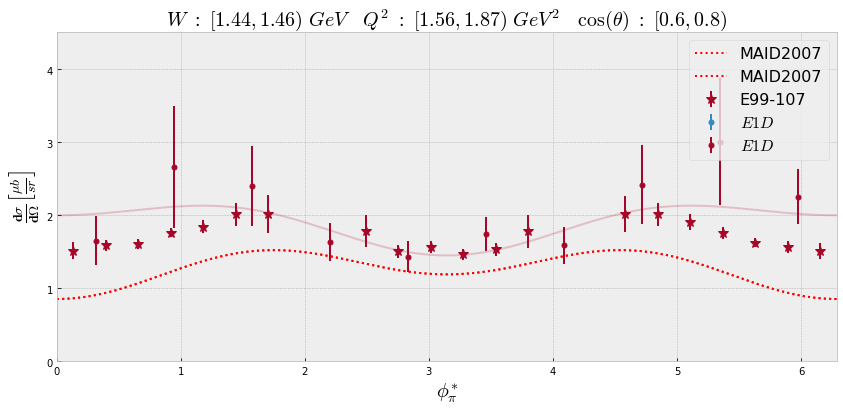

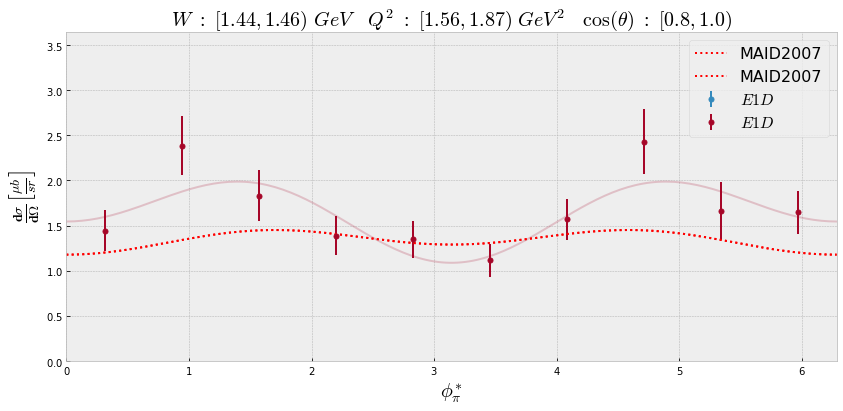

In [14]:
for w in [1.44]:
    for q2 in [1.56]:
        for ct in [0.4, 0.6, 0.8]:
            plotOne(w, q2, ct)

In [6]:
def plotCos(w, q2):
    data1 = df[(df.w_left == w) & (df.q2_left == q2)]
    
    data1RmSec = dfRmSec[(dfRmSec.w_left == w) & (dfRmSec.q2_left == q2)]
    
    w_left = data1.w_left.iloc[0]
    w_right = data1.w_right.iloc[0]
    
    q2_left = data1.q2_left.iloc[0]
    q2_right = data1.q2_right.iloc[0]
    
    fig, axs = plt.subplots(nrows=5,ncols=2, figsize=[20,10])
    for ct in cts:
        data =  data1[(data1.cos_theta == ct)]
        dataRmSec =  data1RmSec[(data1RmSec.cos_theta == ct)]

        a = which_plot[ct][0]
        b = which_plot[ct][1]
        ax = axs[which_plot[ct][0],which_plot[ct][1]]
        if len(data) == 0:
            ax.set_visible(False)
            continue
        maxs = 0.0
        for k, v in overlapSettings.items():
            odata = overlap[(overlap.W_min == w) & (overlap.Q2_min == q2) & (overlap.cos_t == ct) & (overlap.experiment == k)]
            if len(odata) == 0:
                continue
            ax.errorbar(odata.phi, odata.y, yerr=odata.yerr, marker=v['symbol'], linestyle="", c=v['color'], markersize=10)
            maxs = np.max(odata.y)

        names = {
                 "All Sec.": {"data": data, "color": COLOR_BLUE},
                 "Sec. Removed": {"data": dataRmSec, "color": COLOR_ORANGE},
                }
        for name in names:
            d = names[name]["data"]
            errorCut = (d.err < 1.0)
            if np.sum(errorCut) < 3:
                continue
            ebar = ax.errorbar(d[errorCut].x, d[errorCut].y, yerr=d[errorCut].err, 
                               fmt='.', markersize=10, label=f'{name}',
                              c=names[name]["color"])
            out = fit_model(ax, d[errorCut].x, d[errorCut].y, ebar[0].get_color(), error=d[errorCut].y)
            try:
                top = np.max(data.y)*TOPFAC
            except ValueError:
                top = np.nan

        maid_top = plot_maid_model(ax, w, q2, ct)


        ax.legend(loc='upper right',fontsize='xx-small', title=f"{plot_label[ct]}")
        ax.set_ylabel(r'$\frac{\mathbf{d}\sigma}{\mathbf{d} \Omega} \left[\frac{\mu b}{sr}\right]$')
        ax.set_xlabel(r'$\phi_{\pi}^{*}$')
        plt.suptitle(f"$W~:~[{w_left},{w_right})~GeV~~~Q^2~:~[{q2_left},{q2_right})~GeV^2~$", fontsize=20)




        if np.isnan(top) or np.isinf(top):
            ax.set_ylim(bottom=0, top=1.0)
        else:
            ax.set_ylim(bottom=0, top=max(max(top, maid_top), maxs)*1.1)
            
    
    plt.xlim(0, 2*np.pi)
    plt.show()

In [7]:
# for w in [1.44]:
#     for q2 in [1.1, 1.87]:
#         plotCos(w, q2)

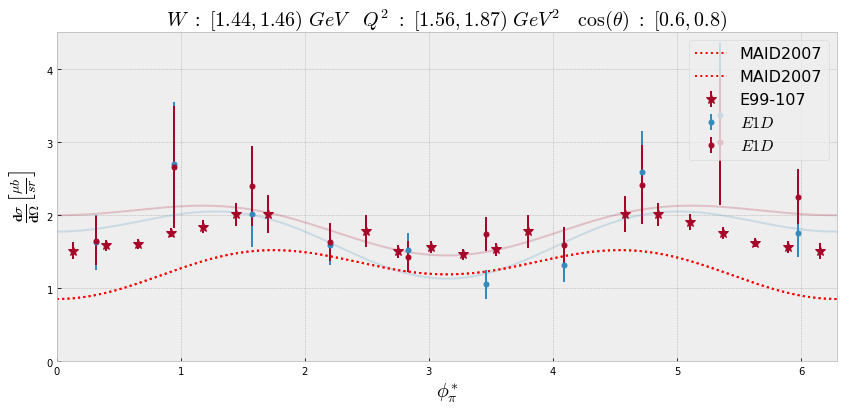

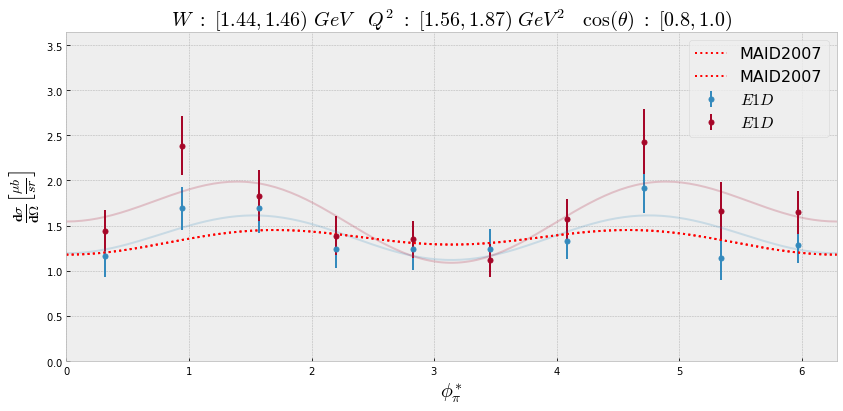

In [8]:
for w in [1.44]:
    for q2 in [1.56]:
        for ct in [0.6, 0.8]:
            plotOne(w, q2, ct)

In [9]:
def plotCosCompare(w, q2):
    which_plot = {
        -0.6: [0, 0],
        -0.4: [0, 1],
        -0.2: [1, 0],
        0.0: [1, 1],
        0.2: [2, 0],
        0.4: [2, 1],
        0.6: [3, 0],
        0.8: [3, 1]
    }
    data1 = df[(df.w_left == w) & (df.q2_left == q2)]
    
    data1RmSec = dfRmSec[(dfRmSec.w_left == w) & (dfRmSec.q2_left == q2)]
    
    w_left = data1.w_left.iloc[0]
    w_right = data1.w_right.iloc[0]
    
    q2_left = data1.q2_left.iloc[0]
    q2_right = data1.q2_right.iloc[0]
    
    fig, axs = plt.subplots(nrows=4,ncols=2, figsize=[18,10])
    for ct in which_plot.keys():
        data =  data1[(data1.cos_theta == ct)]
        dataRmSec =  data1RmSec[(data1RmSec.cos_theta == ct)]
        if len(data) == 0:
            continue
        a = which_plot[ct][0]
        b = which_plot[ct][1]
        ax = axs[which_plot[ct][0],which_plot[ct][1]]
        maxs = 0.0
        for k, v in overlapSettings.items():
            odata = overlap[(overlap.W_min == w) & (overlap.Q2_min == q2) & (overlap.cos_t == ct) & (overlap.experiment == k)]
            if len(odata) == 0:
                continue
            ax.errorbar(odata.phi, odata.y, yerr=odata.yerr, marker=v['symbol'], linestyle="", c=v['color'], markersize=10)
            maxs = np.max(odata.y)

        names = {
                 "$E1D$": {"data": data, "color": COLOR_BLUE},
                 "Sec. Removed": {"data": dataRmSec, "color": COLOR_ORANGE},
                }
        for name in names:
            d = names[name]["data"]
            errorCut = (d.err < 1.0)
            if np.sum(errorCut) < 3:
                continue
            ebar = ax.errorbar(d[errorCut].x, d[errorCut].y, yerr=d[errorCut].err, 
                               fmt='.', markersize=10, label=f'{name}',
                              c=names[name]["color"])
            out = fit_model(ax, d[errorCut].x, d[errorCut].y, ebar[0].get_color())
            try:
                top = np.max(d[errorCut].y)*TOPFAC
            except ValueError:
                top = np.nan

        maid_top = plot_maid_model(ax, w, q2, ct, name="MAID2007")


        ax.legend(loc='upper right',fontsize='xx-small', title=f"{plot_label[ct]}")
        ax.set_ylabel(r'$\frac{\mathbf{d}\sigma}{\mathbf{d} \Omega} \left[\frac{\mu b}{sr}\right]$')
        
        if which_plot[ct][0] == 3:
            ax.set_xlabel(r'$\phi_{\pi}^{*}$')
        
        plt.suptitle(f"$W~:~[{w_left},{w_right})~GeV~~~Q^2~:~[{q2_left},{q2_right})~GeV^2~$", fontsize=20)




        if np.isnan(top) or np.isinf(top):
            ax.set_ylim(bottom=0, top=1.0)
        else:
            ax.set_ylim(bottom=0, top=max(max(top, maid_top), maxs*1.2))
    
    plt.xlim(0, 2*np.pi)
    plt.show()

In [10]:
for w in [1.44]:
    for q2 in [1.1, 1.56]:
        plotCosCompare(w, q2)

NameError: name 'df' is not defined